In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Download Datasets from Kaggle
Use Kaggle API to download the ExpW, AffectNet, and RAF-DB datasets.

In [8]:
# Download Datasets from Kaggle
# %pip install kaggle

os.environ['KAGGLE_USERNAME'] = 'tim0820'
os.environ['KAGGLE_KEY'] = '3ff6e6a532021856f5340aab0f4c1c89'

# Download ExpW dataset
!kaggle datasets download -d shahzadabbas/expression-in-the-wild-expw-dataset
!kaggle datasets download -d noamsegal/affectnet-training-data
!kaggle datasets download -d shuvoalok/raf-db-dataset

404 - Not Found
404 - Not Found
404 - Not Found


# Load and Explore Datasets
Load the datasets into pandas DataFrames and explore their structure and contents.

In [ ]:
import zipfile

# Unpack RAF-DB dataset
with zipfile.ZipFile('raf-db-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./datasets/rafdb')

# Unpack ExpW dataset
with zipfile.ZipFile('expression-in-the-wild-expw-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./datasets/expw')

# Unpack AffectNet dataset
with zipfile.ZipFile('affectnet-training-data.zip', 'r') as zip_ref:
    zip_ref.extractall('./datasets/affectnet')

affectnet structure:
folders named anger, contempt(we don't need that one), disgust, fear, happy, neutral, sad, suprise
each contain images 96*96


rafdb structure:
train_labels.csv (image,label) test_labels.csv (image,label) (need to merge them) where label is int from 1 to 7
2 directories test and train each contin dirs from 1 to 7 (emotions) with images 100*100

expw structure:
label.lst： each line indicates an image as follows:
image_name face_id_in_image face_box_top face_box_left face_box_right face_box_bottom face_box_cofidence expression_label (the only one we actually need)

for expression label：
"0" "angry"
"1" "disgust"
"2" "fear"
"3" "happy"
"4" "sad"
"5" "surprise"
"6" "neutral"

there is parted 7z archive in expw dir, first need to unpack it using 7z commandline tool
unpacked content in datasets/expw/origin

In [2]:
# Define paths to the directories
affectnet_dir = './datasets/affectnet'
rafdb_train_dir = './datasets/rafdb/DATASET/train'
rafdb_test_dir = './datasets/rafdb/DATASET/test'

# Define a function to parse AffectNet dataset
def parse_affectnet(directory):
    data = []
    for emotion in ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']:
        emotion_dir = os.path.join(directory, emotion)
        for img_name in os.listdir(emotion_dir):
            img_path = os.path.join(emotion_dir, img_name)
            data.append({'image': img_path, 'expression': emotion})
    return pd.DataFrame(data)

# Define a function to parse RAF-DB dataset
def parse_rafdb(train_dir, test_dir):
    data = []
    for emotion in range(1, 8):  # Emotions are labeled from 1 to 7
        emotion_dir_train = os.path.join(train_dir, str(emotion))
        emotion_dir_test = os.path.join(test_dir, str(emotion))
        for img_name in os.listdir(emotion_dir_train):
            img_path = os.path.join(emotion_dir_train, img_name)
            data.append({'image': img_path, 'expression': emotion})
        for img_name in os.listdir(emotion_dir_test):
            img_path = os.path.join(emotion_dir_test, img_name)
            data.append({'image': img_path, 'expression': emotion})
    return pd.DataFrame(data)

# Parse AffectNet dataset
affectnet_df = parse_affectnet(affectnet_dir)
print("\nParsed AffectNet Dataset:")
print(affectnet_df.head())

# Parse RAF-DB dataset
rafdb_df = parse_rafdb(rafdb_train_dir, rafdb_test_dir)
print("\nParsed RAF-DB Dataset:")
print(rafdb_df.head())


Parsed AffectNet Dataset:
                                         image expression
0  ./datasets/affectnet/anger/image0000006.jpg      anger
1  ./datasets/affectnet/anger/image0000060.jpg      anger
2  ./datasets/affectnet/anger/image0000061.jpg      anger
3  ./datasets/affectnet/anger/image0000066.jpg      anger
4  ./datasets/affectnet/anger/image0000106.jpg      anger

Parsed RAF-DB Dataset:
                                               image  expression
0  ./datasets/rafdb/DATASET/train/1/train_00006_a...           1
1  ./datasets/rafdb/DATASET/train/1/train_00010_a...           1
2  ./datasets/rafdb/DATASET/train/1/train_00012_a...           1
3  ./datasets/rafdb/DATASET/train/1/train_00013_a...           1
4  ./datasets/rafdb/DATASET/train/1/train_00032_a...           1


In [ ]:
!7z x origin.7z.001

In [3]:
# Define a function to parse ExpW dataset
def parse_expw(directory):
    data = []
    label_file = os.path.join(directory, 'label.lst')
    with open(label_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            image_name = parts[0]
            expression_label = int(parts[-1])
            img_path = os.path.join(directory, 'origin', image_name)
            data.append({'image': img_path, 'expression': expression_label})
    return pd.DataFrame(data)

# Define the path to the ExpW dataset directory
expw_dir = './datasets/expw'

# Parse ExpW dataset
expw_df = parse_expw(expw_dir)
print("\nParsed ExpW Dataset:")
print(expw_df.head())


Parsed ExpW Dataset:
                                        image  expression
0  ./datasets/expw/origin/angry_actor_104.jpg           0
1  ./datasets/expw/origin/angry_actor_109.jpg           0
2  ./datasets/expw/origin/angry_actor_120.jpg           2
3   ./datasets/expw/origin/angry_actor_13.jpg           3
4  ./datasets/expw/origin/angry_actor_132.jpg           0


# Normalize and Standardize Data
Normalize and standardize the data to ensure consistency across all datasets.

In [11]:
from PIL import Image
from tqdm import tqdm

def resize_image(image_path, size=(96, 96)):
    with Image.open(image_path) as img:
        img = img.resize(size, Image.LANCZOS)
        img.save(image_path)

resized_train_dir = './datasets/rafdb/DATASET/resized_train'
resized_test_dir = './datasets/rafdb/DATASET/resized_test'

for emotion in range(1, 8):
    emotion_dir = os.path.join(rafdb_train_dir, str(emotion))
    for img_name in tqdm(os.listdir(emotion_dir), desc=f'Resizing train images for emotion {emotion}'):
        img_path = os.path.join(emotion_dir, img_name)
        resize_image(img_path)

for emotion in range(1, 8):
    emotion_dir = os.path.join(rafdb_test_dir, str(emotion))
    for img_name in tqdm(os.listdir(emotion_dir), desc=f'Resizing test images for emotion {emotion}'):
        img_path = os.path.join(emotion_dir, img_name)
        resize_image(img_path)


Resizing test images for emotion 7: 100%|██████████| 680/680 [00:00<00:00, 1536.86it/s]


In [4]:
from rzd_detector.codemodules.face.emotions.landmarks import FaceLandmarksProcessor
from tqdm import tqdm
from PIL import Image


[02/19/2025 16:51:29 | INFO]:  >>> ---- Module reimported! ---- <<< 


logger name: rzd_detector
logger name: rzd_detector


2025-02-19 16:51:29.820980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-19 16:51:29.837279: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-19 16:51:29.842065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 16:51:29.854298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-19 16:51:30.802843: W tensorflow/compiler/tf2

In [ ]:
def process_and_resize_expw_image(image_path):
    # Use the same file path but temporarily save as png
    base, _ = os.path.splitext(image_path)
    temp_png_path = f"{base}.png"

    processor_instance = FaceLandmarksProcessor(verbose=False)
    # print(f"Processing landmarks for {image_path}")
    result = processor_instance.process_landmarks(
        image_path,
        save_path=temp_png_path,
        return_raw=False,
        hide_eyes=False,
        hide_mouth=False,
        transparent_bg=True,
        curve_crop=False,
    )

    if result is None:
        print(f"No face detected in {image_path}, skipping this image.")
        if os.path.exists(temp_png_path):
            os.remove(temp_png_path)
        return

    # Open the processed png image and resize to 96x96
    with Image.open(temp_png_path) as img:
        img_resized = img.resize((96, 96), Image.LANCZOS).convert("RGB")
        # Save as jpg (using same base name with .jpg)
        new_jpg_path = f"{base}.jpg"
        img_resized.save(new_jpg_path, format="JPEG")
        # print(f"Resized and saved to {new_jpg_path}")

    # Remove the temporary png file
    os.remove(temp_png_path)

# Process only images from the expw dataset
for idx, row in tqdm(expw_df.iterrows(), total=len(expw_df), desc="Processing expw images"):
    image_path = row["image"]
    process_and_resize_expw_image(image_path)

In [5]:
base_dir = os.path.join(expw_dir, 'origin')
valid_count = 0
invalid_count = 0
deleted_files = []

print(f"Processing {base_dir}")
for fname in tqdm(os.listdir(base_dir)):
    file_path = os.path.join(base_dir, fname)
    try:
        with Image.open(file_path) as img:
            if img.size == (96, 96):
                valid_count += 1
            else:
                invalid_count += 1
                deleted_files.append(file_path)
    except Exception as e:
        print(f"Error opening {file_path}: {e}")

print(f"Valid images (96x96): {valid_count}")
print(f"Invalid images: {invalid_count}")

expw_df = expw_df[~expw_df['image'].isin(deleted_files)]

Processing ./datasets/expw/origin


100%|██████████| 106962/106962 [00:11<00:00, 9613.39it/s] 

Valid images (96x96): 43265
Invalid images: 63697


In [6]:
# del paths from  expw_df of files that do not exist
expw_df = expw_df[expw_df['image'].apply(lambda x: os.path.exists(x))]
expw_df.reset_index(drop=True, inplace=True)

rafdb_df = rafdb_df[rafdb_df['image'].apply(lambda x: os.path.exists(x))]
rafdb_df.reset_index(drop=True, inplace=True)

affectnet_df = affectnet_df[affectnet_df['image'].apply(lambda x: os.path.exists(x))]
affectnet_df.reset_index(drop=True, inplace=True)

our scheme {'surprise': 0, 'fear': 1, 'disgust': 2, 'happy': 3, 'sad': 4, 'angry': 5, 'neutral': 6}
(rafdb has the same +1)

In [7]:
expression_mapping = {'surprise': 0, 'fear': 1, 'disgust': 2, 'happy': 3, 'sad': 4, 'anger': 5, 'neutral': 6}
affectnet_df['expression'] = affectnet_df['expression'].map(expression_mapping)

print("\nAffectNet Dataset:")
print(affectnet_df.head())


AffectNet Dataset:
                                         image  expression
0  ./datasets/affectnet/anger/image0000006.jpg           5
1  ./datasets/affectnet/anger/image0000060.jpg           5
2  ./datasets/affectnet/anger/image0000061.jpg           5
3  ./datasets/affectnet/anger/image0000066.jpg           5
4  ./datasets/affectnet/anger/image0000106.jpg           5


In [8]:
rafdb_df['expression'] = rafdb_df['expression'] - 1

# Display the updated DataFrame
print("\nRAF-DB Dataset with 0-based Labels:")
print(rafdb_df.head())


RAF-DB Dataset with 0-based Labels:
                                               image  expression
0  ./datasets/rafdb/DATASET/train/1/train_00006_a...           0
1  ./datasets/rafdb/DATASET/train/1/train_00010_a...           0
2  ./datasets/rafdb/DATASET/train/1/train_00012_a...           0
3  ./datasets/rafdb/DATASET/train/1/train_00013_a...           0
4  ./datasets/rafdb/DATASET/train/1/train_00032_a...           0


In [9]:
# Remap expw labels according to the new mapping:
# 0 ("angry") -> "anger": 5,
# 1 ("disgust") -> "disgust": 2,
# 2 ("fear") -> "fear": 1,
# 3 ("happy") -> "happy": 3,
# 4 ("sad") -> "sad": 4,
# 5 ("surprise") -> "surprise": 0,
# 6 ("neutral") -> "neutral": 6

expw_mapping = {0: 5, 1: 2, 2: 1, 3: 3, 4: 4, 5: 0, 6: 6}
expw_df['expression'] = expw_df['expression'].map(expw_mapping)

print("\nUpdated ExpW Dataset:")
print(expw_df.head())


Updated ExpW Dataset:
                                        image  expression
0  ./datasets/expw/origin/angry_actor_104.jpg           5
1  ./datasets/expw/origin/angry_actor_109.jpg           5
2  ./datasets/expw/origin/angry_actor_120.jpg           1
3   ./datasets/expw/origin/angry_actor_13.jpg           3
4  ./datasets/expw/origin/angry_actor_132.jpg           5


In [ ]:
# Merge AffectNet, RAF-DB, and ExpW dataframes into a unified DataFrame
merged_df = pd.concat([affectnet_df, rafdb_df, expw_df], ignore_index=True)
print("Combined dataset shape:", merged_df.shape)
print(merged_df.head())

Combined dataset shape: (93442, 2)
                                         image  expression
0  ./datasets/affectnet/anger/image0000006.jpg           5
1  ./datasets/affectnet/anger/image0000060.jpg           5
2  ./datasets/affectnet/anger/image0000061.jpg           5
3  ./datasets/affectnet/anger/image0000066.jpg           5
4  ./datasets/affectnet/anger/image0000106.jpg           5


[02/19/2025 20:09:51 | INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[02/19/2025 20:09:51 | INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


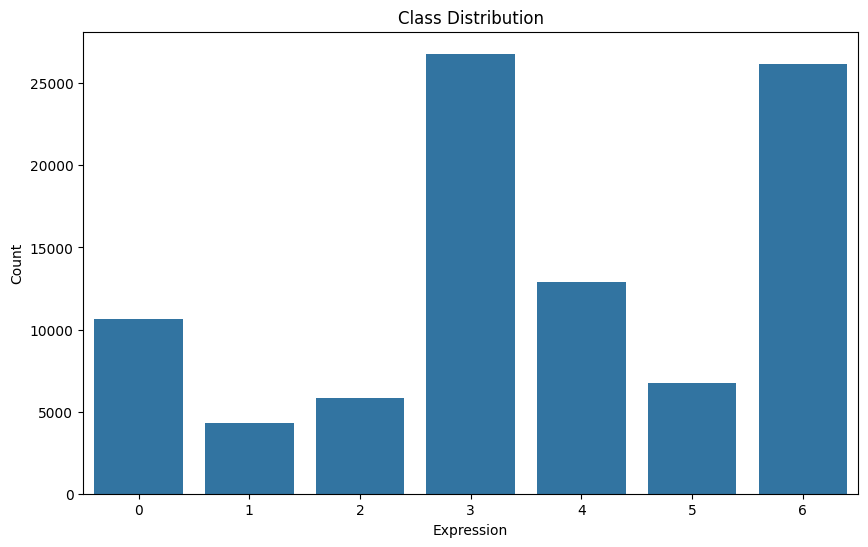

In [45]:
# show class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='expression', data=merged_df)
plt.title('Class Distribution')
plt.xlabel('Expression')
plt.ylabel('Count')
plt.show()

/tmp/ipykernel_14921/1041085929.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = merged_df.groupby('expression', group_keys=False).apply(preferential_sample).reset_index(drop=True)
[02/19/2025 20:09:51 | INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[02/19/2025 20:09:51 | INFO]: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Balanced class distribution:
expression
0    4336
1    4336
2    4336
3    4336
4    4336
5    4336
6    4336
Name: count, dtype: int64


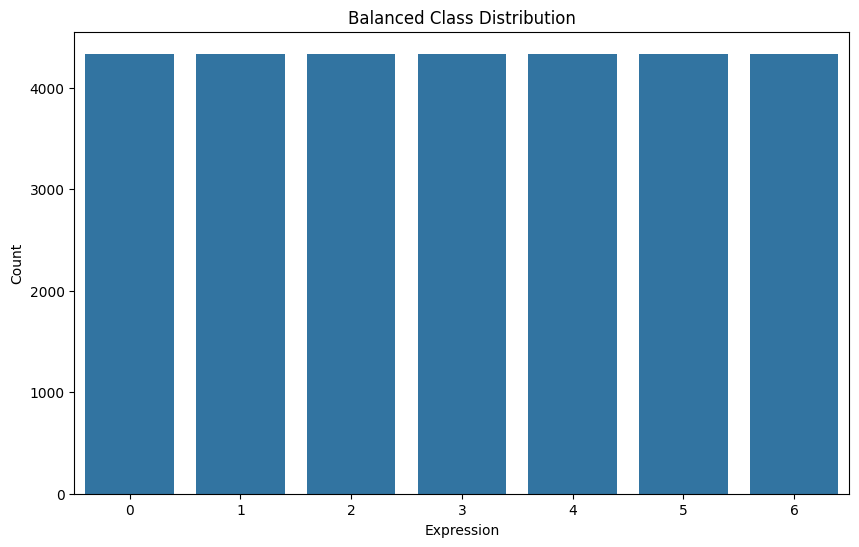

In [46]:
min_count = merged_df['expression'].value_counts().min()

def preferential_sample(group):
    # Partition the group into affectnet and others:
    aff = group[group['dataset'] == 'affectnet']
    non_aff = group[group['dataset'].isin(['expw', 'rafdb'])]
    
    # If the affectnet subset already meets or exceeds the required count, keep only those.
    if len(aff) >= min_count:
        return aff.sample(min_count)
    # Otherwise, take all affectnet samples and fill up from the others.
    else:
        remaining = min_count - len(aff)
        sampled_non_aff = non_aff.sample(remaining) if len(non_aff) >= remaining else non_aff
        return pd.concat([aff, sampled_non_aff])

balanced_df = merged_df.groupby('expression', group_keys=False).apply(preferential_sample).reset_index(drop=True)

print("Balanced class distribution:")
print(balanced_df['expression'].value_counts())

# show class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='expression', data=balanced_df)
plt.title('Balanced Class Distribution')
plt.xlabel('Expression')
plt.ylabel('Count')
plt.show()

In [51]:
print(balanced_df.info())
print(balanced_df.describe())
print(balanced_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30352 entries, 0 to 30351
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       30352 non-null  object
 1   expression  30352 non-null  int64 
 2   dataset     30352 non-null  object
dtypes: int64(1), object(2)
memory usage: 711.5+ KB
None
         expression
count  30352.000000
mean       3.000000
std        2.000033
min        0.000000
25%        1.000000
50%        3.000000
75%        5.000000
max        6.000000
                                        image  expression    dataset
0    ./datasets/affectnet/surprise/ffhq_1.png           0  affectnet
1   ./datasets/affectnet/surprise/ffhq_10.png           0  affectnet
2  ./datasets/affectnet/surprise/ffhq_100.png           0  affectnet
3  ./datasets/affectnet/surprise/ffhq_101.png           0  affectnet
4  ./datasets/affectnet/surprise/ffhq_102.png           0  affectnet


In [53]:
# save to csv
balanced_df.to_csv('merged_dataset.csv', index=False)

In [54]:
# load from csv
balanced_df = pd.read_csv('merged_dataset.csv')
print(balanced_df.head())

                                        image  expression    dataset
0    ./datasets/affectnet/surprise/ffhq_1.png           0  affectnet
1   ./datasets/affectnet/surprise/ffhq_10.png           0  affectnet
2  ./datasets/affectnet/surprise/ffhq_100.png           0  affectnet
3  ./datasets/affectnet/surprise/ffhq_101.png           0  affectnet
4  ./datasets/affectnet/surprise/ffhq_102.png           0  affectnet


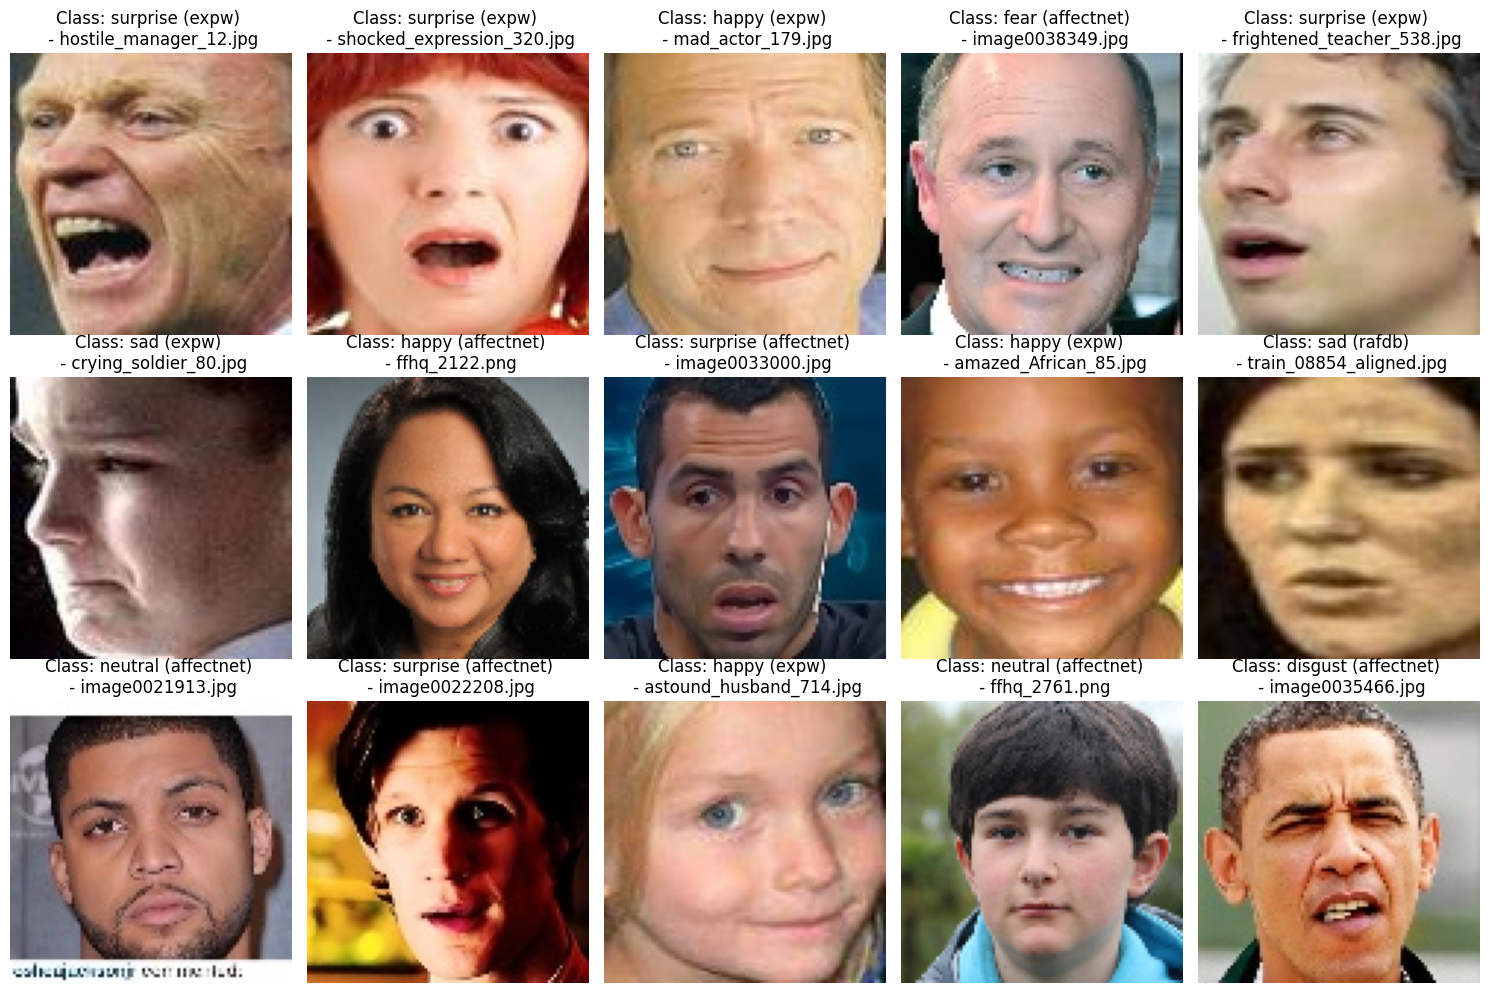

In [52]:
# show grid of 15 ransom images from random dataset (affectnet, rafdb, expw randomly selected) of random class
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
expression_mapping = {'surprise': 0, 'fear': 1, 'disgust': 2, 'happy': 3, 'sad': 4, 'angry': 5, 'neutral': 6}
expression_mapping = {v: k for k, v in expression_mapping.items()}

random_images = random.sample(range(len(merged_df)), 15)
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
for i, idx in enumerate(random_images):
    image_path = merged_df.iloc[idx]['image']
    expression = merged_df.iloc[idx]['expression']
    dataset_name = image_path.split('/')[2]
    filename = image_path.split('/')[-1]
    img = mpimg.imread(image_path)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Class: {expression_mapping[expression]} ({dataset_name}) \n - {filename}')
plt.tight_layout()
plt.show()
